In [311]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats


# AB Testing: Evaluating the Effect of Marketing/Product Changes

**Goal:** Determine whether changes to marketing materials, webpage design, or products result in increased performance.

**Overview:** Why use statistics/T-Test to evaluate programs? Why not just calculate the average of those served the change versus those not served the change?

Statistics/T-Testing allows us to incorporate the likliehood that differences between calaculated metric averages of two groups are the product of chance into our analysis. If we just compare the average conversion rate of customers served the change and customers not served the change, we fail to account for uncertainty caused by the variation of data within each group or small sample sizes.    


# AB Testing: Treatment and Control

**When planning AB Testing a New Feature, we must:**

1) Choose metrics most relevant for analysis. This is a company specific question. What do you hope the new feature will accomplish. Increased conversion rates, increased time on the app, increased Daily Active Users, increased spending, etc...

2) Randomly split customer base being used for testing into two groups. Treatment/Control. The treatment group are customers being exposed to the new feature. The control group are the customers being served the original product. 

3) Choose a hypothesis to test. For the purpose of this analysis, we will test whether product changes cause any meaningful difference to metrics of interest. To accomplish this, in statistics, we test whether we can reject that there is no change.  

4) Determine how big the effect size has to be for it to be of consequence to the company and determine what sample size is needed to detect that effect. 


In [312]:
####List of Users
fb_users = pd.read_csv("/Users/james/Desktop/MIT Data Science Masters/AB Testing/facebook_ad_campaign_dataset_no_results.csv")
fb_users


,user_id,reporting_start,reporting_end,age,gender,interest1,interest2,interest3
0,708746,17/08/2017,17/08/2017,30-34,M,15,17,17
1,708749,17/08/2017,17/08/2017,30-34,M,16,19,21
2,708771,17/08/2017,17/08/2017,30-34,M,20,25,22
3,708815,30/08/2017,30/08/2017,30-34,M,28,32,32
4,708818,17/08/2017,17/08/2017,30-34,M,28,33,32
...,...,...,...,...,...,...,...,...
1138,1314410,19/08/2017,19/08/2017,45-49,F,109,111,114
1139,1314411,19/08/2017,19/08/2017,45-49,F,110,111,116
1140,1314412,19/08/2017,19/08/2017,45-49,F,111,113,117
1141,1314414,17/08/2017,17/08/2017,45-49,F,113,114,117


**Stratification:** Generally, you want the characteristics of your treatment and control group to be as similar as possible. Random assignment helps minimize selection bias and reduce the chance of unrepresentative groups. Since we have user age and gender Information, to help assure representative groups, we seperate users into buckets seperated by age and gender before randomly assigning users. 

In [313]:
###Check the number of users in each age group###
fb_users['age'].value_counts()

30-34    426
45-49    259
35-39    248
40-44    210
Name: age, dtype: int64

In [314]:
###Check the number of users in each gender group###
fb_users['gender'].value_counts()

M    592
F    551
Name: gender, dtype: int64

In [315]:
####Split Data Into Male and Female Groups
fb_users_M=fb_users[fb_users['gender']=='M']
fb_users_F=fb_users[fb_users['gender']=='F']

In [316]:
#####Randomly assign treatment and control status stratified by age group. 
np.random.seed( 111)
d = {"30-34":[.5,.5],"45-49":[.5,.5],"35-39":[.5,.5],"40-44":[.5,.5] }

fb_users_M['Treatment_Status'] = \
fb_users_M.groupby('age')['user_id'] \
   .transform(lambda x: np.random.choice([0,1], len(x), p=d[x.name]))



/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [317]:
np.random.seed( 112)
d = {"30-34":[.5,.5],"45-49":[.5,.5],"35-39":[.5,.5],"40-44":[.5,.5] }

fb_users_F['Treatment_Status'] = \
fb_users_F.groupby('age')['user_id'] \
   .transform(lambda x: np.random.choice([0,1], len(x), p=d[x.name]))

/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [318]:
fb_users_M['Treatment_Status'].value_counts()

0    309
1    283
Name: Treatment_Status, dtype: int64

In [319]:
fb_users_F['Treatment_Status'].value_counts()

0    285
1    266
Name: Treatment_Status, dtype: int64

In [320]:
frames = [fb_users_M, fb_users_F]

fb_users_treatment_status= pd.concat(frames)
fb_users_treatment_status

,user_id,reporting_start,reporting_end,age,gender,interest1,interest2,interest3,Treatment_Status
0,708746,17/08/2017,17/08/2017,30-34,M,15,17,17,1
1,708749,17/08/2017,17/08/2017,30-34,M,16,19,21,0
2,708771,17/08/2017,17/08/2017,30-34,M,20,25,22,0
3,708815,30/08/2017,30/08/2017,30-34,M,28,32,32,1
4,708818,17/08/2017,17/08/2017,30-34,M,28,33,32,0
...,...,...,...,...,...,...,...,...,...
1138,1314410,19/08/2017,19/08/2017,45-49,F,109,111,114,1
1139,1314411,19/08/2017,19/08/2017,45-49,F,110,111,116,0
1140,1314412,19/08/2017,19/08/2017,45-49,F,111,113,117,0
1141,1314414,17/08/2017,17/08/2017,45-49,F,113,114,117,1


# Collect Metrics for Each Group After Change
At this stage, we collect metrics identified as useful on users in treatment and control groups. 


In [321]:
user_results = pd.read_csv("/Users/james/Desktop/MIT Data Science Masters/AB Testing/facebook_ad_campaign_dataset_results.csv")


In [322]:
#######Merge Data with Results ######

user_results_full = pd.merge(fb_users_treatment_status, user_results, on='user_id')
user_results_full

,user_id,reporting_start,reporting_end,age,gender,interest1,interest2,interest3,Treatment_Status,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,17/08/2017,17/08/2017,30-34,M,15,17,17,1,7350,1,1.430000,2,1
1,708749,17/08/2017,17/08/2017,30-34,M,16,19,21,0,17861,2,1.820000,2,0
2,708771,17/08/2017,17/08/2017,30-34,M,20,25,22,0,693,0,0.000000,1,0
3,708815,30/08/2017,30/08/2017,30-34,M,28,32,32,1,4259,1,1.250000,1,0
4,708818,17/08/2017,17/08/2017,30-34,M,28,33,32,0,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,19/08/2017,19/08/2017,45-49,F,109,111,114,1,1129773,252,358.189997,13,2
1139,1314411,19/08/2017,19/08/2017,45-49,F,110,111,116,0,637549,120,173.880003,3,0
1140,1314412,19/08/2017,19/08/2017,45-49,F,111,113,117,0,151531,28,40.289999,2,0
1141,1314414,17/08/2017,17/08/2017,45-49,F,113,114,117,1,790253,135,198.710000,8,2


# Review Pair Plots and Evaluate the Normality of the Distribution of Various Metrics

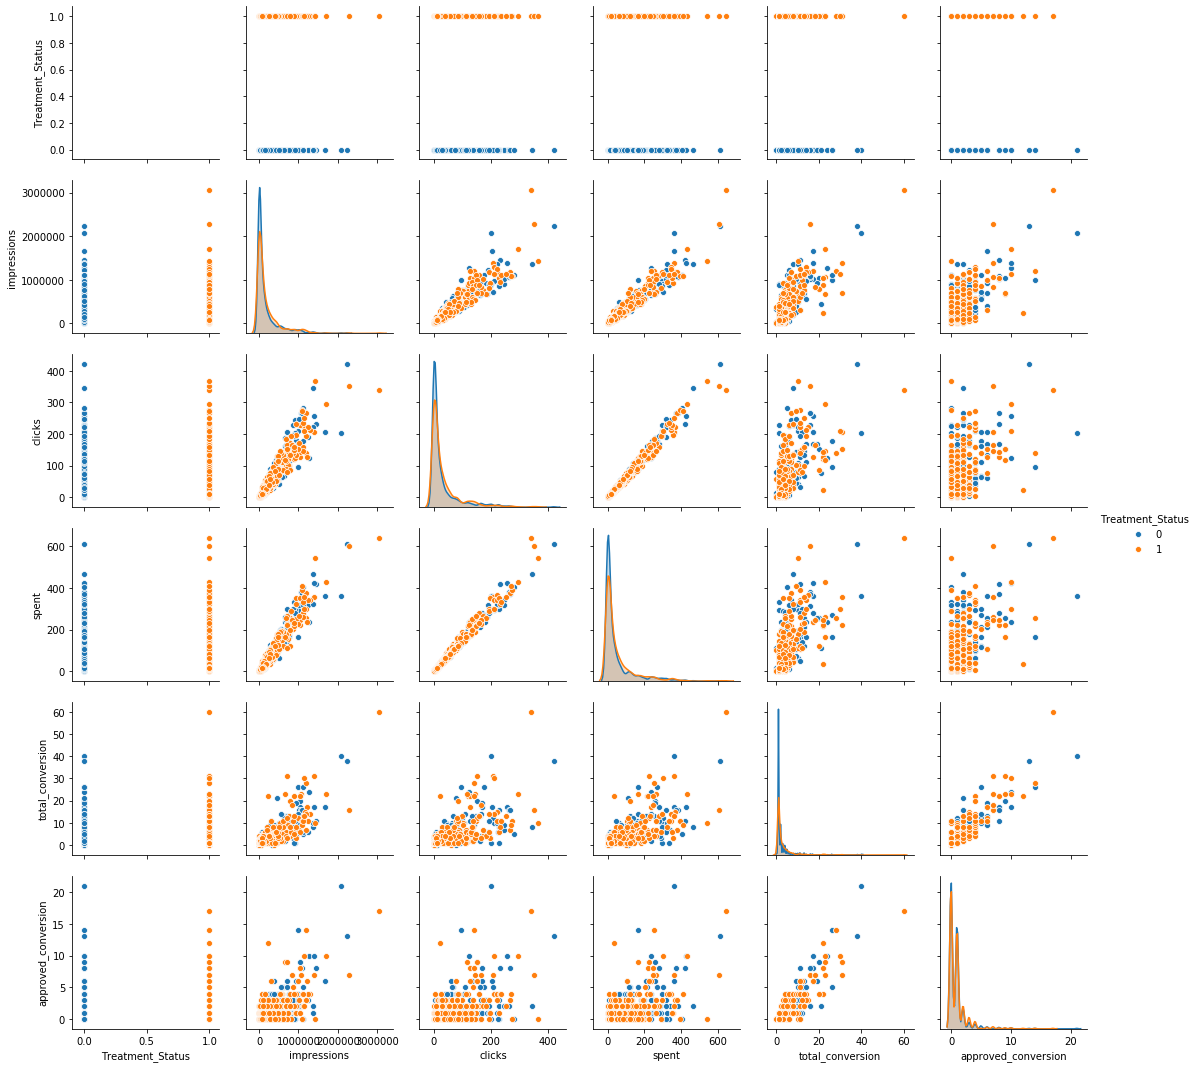

In [323]:
###Use Seaborn to create a pair plot of metrics seperating treatment and control.
pp=user_results_full[['Treatment_Status','impressions','clicks','spent','total_conversion','approved_conversion']]
sns.pairplot(pp, hue="Treatment_Status")


# Testing Normality  
**Skew**:Normally distributed data is symetrical around the mean. i.e. median = mean. Our metrics have a positive skew and is skewed to the right with a long left tail. 

In [324]:
####Calculate Skew:
pp.skew(axis=0)


Treatment_Status       0.078905
impressions            3.010185
clicks                 2.712187
spent                  2.708867
total_conversion       5.095919
approved_conversion    4.837539
dtype: float64

**Kolmogorov–Smirnov Normality Test(KL Test)**: Measures the largest difference between a normal CDF and our datas CDF to determine whether the data is normally distributed. 

**P-Value** < 0.05 (significance level), reject that they are drawn from same distribution.

Statistic greater than critical value reject null. 

In [325]:
####KS Test
pp_ac=pp[['approved_conversion']]
stats.kstest(pp_ac,'norm')


KstestResult(statistic=1.0, pvalue=0.0)

**Conclusion**: The pair plots illustrate that the distribution of our evaluation metrics are more exponential than normal. If we want further confirmation of this conclusion, we can look to our KS Test and calculated skew. Since our metric distributions are not normally distributed, we cannot perform a two sample t-stat test. 

# Bootstrapping Technique

**Goal: Test whether changes to the website lead to increased purchase of the product. This is represented by the approved_conversion category.**   

Our goal is to determine whether the means of the two groups are statistically different. Unfortunately, we cannot directly t test the data because none of our metrics appear normally distributed. Instead, we will use a technique called bootstrapping. It leverages the idea that  if we take sets of random samples from a distribution, calculate their mean, and create a histogram. The resulting plot should be normally distributed around the mean. Assuming the original sample is randomly selected and representative of the population, sampling from it multiple times will also be representative. Note: Boot strap tests are approximations and have limitations. 

In [326]:
#####Seperate Results Data into Treatment and Control 
fb_users_Treat=user_results_full[user_results_full['Treatment_Status']==1]
fb_users_Control=user_results_full[user_results_full['Treatment_Status']==0]

In [327]:
fb_users_Treat[['approved_conversion']].var()

approved_conversion    3.087538
dtype: float64

In [328]:
fb_users_Control[['approved_conversion']].var()

approved_conversion    2.957739
dtype: float64

Note: Technically, since the variance of the treatment and control are approximately equal, we can subtract the two means without adjusting for different variances.  

# Step 1: Use Cohen's ds to find a reasonable minimal detectable effect (MDE) size for the power equation. 

The MDE is the smallest difference in effect you want your what your test to be able to pick up. Theoretically, you can choose any MDE. Generally, the lower the MDE the more sample size will be required to run the analysis. Cohen's d is a preliminary test that estimates the difference between the two group's means in standard deviations. The appropriate MDE is largely field specific. IF sample size is an issue, MDE could be chosen based on what effect size will likely be relevant to a companies decision making. Cohen thought .8 represents a large effect size, .5 represents a medium effect size, and .2 represents a small effect size. He suggested any difference below .2 standard deviations is trivial, even if significant. 


\begin{equation*}
CohensDs = \frac{Mean_T-Mean_C}{PooledStandardDeviation} 
\end{equation*}



\begin{equation*}
PooledSD = \sqrt{\frac{((n_c-1)*SD_c^2) +((n_t-1)*SD_t^2)}{n_t+n_c-2}}
\end{equation*}

In [329]:
##Step 1a: Use Cohen's ds to find appropriate MDE for power equation. 
###Cohen's ds = (MeanT-MeanC) / Pooled SD
#####Since we have unequal group sizes, 
nt=len(fb_users_Treat) 
nc=len(fb_users_Control) 
SDt=np.std(fb_users_Treat[['approved_conversion']])
SDc=np.std(fb_users_Control[['approved_conversion']])
meanT=fb_users_Treat[['approved_conversion']].mean()
meanC=fb_users_Control[['approved_conversion']].mean()

In [330]:
pooled_SD = np.sqrt((((nc-1)*SDc**2) + ((nt-1)*SDt**2))/(nc+nt-2))
pooled_SD

approved_conversion    1.736315
dtype: float64

In [331]:
Cohen_Ds_MDE = (meanT-meanC)/ pooled_SD
Cohen_Ds_MDE


approved_conversion    0.053979
dtype: float64

**Conclusion:** Cohen's d tells us that the treatment and the control distributions are very, very close. Only .05 standard deviations apart. This gives us an indication that we are unlikely to find a meaningful difference between the groups based on the change. It is also an indication that to assure a statistically significant result we will need a large sample size. 

# Step 2: Use the power equation to find the required sample size. 

\begin{equation*}
SampleSize = \frac{MDE^2*P(1-P)}{\Bigl(t_{1-\beta}+t_{\alpha/2}\Bigr)^2} 
\end{equation*}

### Power Equation Variables

Besides MDE, we must also select our desired significance level (alpha) and power(beta) for the test. Significance level represents the likliehood of a Type 1 error (False Positive i.e. Reject Null When True)). Power represents the likliehood of a Type 2 error (False Negative i.e. Fail to Reject When False). Generally, the chosen alpha is .05 or less and the chosen power is above .8. 

**alpha**= .05

**beta**= .10

**power** = .9

Since we want to test whether there is a difference between the treatment and control in either direction, we are using a two sided test. A one sided test allows us to test for a difference in means in a specific direction. For example, does the change cause a positive difference. When performing a two sided test, we must must divide alpha by two before looking up the critical value associated with it. 

In [332]:

#Critical Value for Two Sided (95% CI) alpha/2=.025 ## 
a_crit=1.96

##Choose the desired power level for desired test. This represents the likliehood of a Type 2 Error. 
##I chose a 90% power level. It is common practice to pick a power over 80%.  

##Beta Critical Value for Power=90%; Beta=.1 ##
beta_crit=1.282

####Proportion in Treatment (P)
P=nt/(nc+nt)

#Sample Variance
var=user_results_full[['approved_conversion']].var()

#Min_Detectable_Effect
MDE=Cohen_Ds_MDE

####Note: Since we do not have enough data to test the Minimal Detectable Effect Size 
####Recommended by Cohen_Ds. We reduced the MDE to .5. 
MDE2=.5



In [333]:
###Use re-arranged power equation to calculate sample size required to pick up MDE.

Required_Sample_Size_CohenMDE=(var*(a_crit+beta_crit)**2)/(P*(1-P)*MDE[0]**2)
Required_Sample_Size_CohenMDE

approved_conversion    43638.275797
dtype: float64

In [334]:
###Use re-arranged power equation to calculate sample size required to pick up larger MDE. 
Required_Sample_Size=(var*(a_crit+beta_crit)**2)/(P*(1-P)*MDE2**2)
Required_Sample_Size

approved_conversion    508.596407
dtype: float64

Note: Since we do not have enough data to test the Minimal Detectable Effect Size recommended by Cohen_Ds. The MDE has been increased to .5. We know the effect size is 

# Step 3: Use calculated sample size to resample with replacement from treatment and control 10000 times each and create a list of calculated means. 

Text(0.5, 1.0, 'Treatment Sample Means')

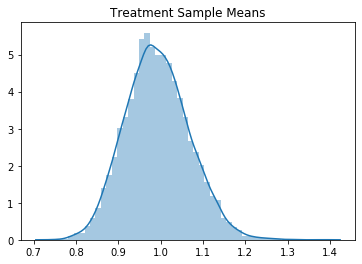

In [335]:
###Treatment Re-sampling
np.random.seed( 113)
sample_means_overall_treatment = []
treat=np.array(fb_users_Treat[['approved_conversion']])
treat=treat.flatten()
for i in range(10000):
    sample_meant = np.random.choice(treat, size=nt).mean()
    sample_means_overall_treatment.append(sample_meant)

####Plot Sampling Distribution (Means)### 
sns.distplot(sample_means_overall_treatment)
plt.title('Treatment Sample Means')

Text(0.5, 1.0, 'Control Sample Means')

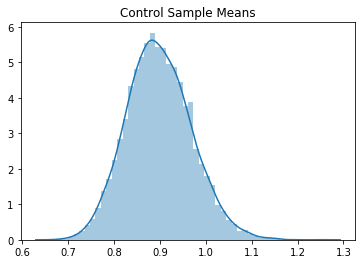

In [336]:
###Control Re-sampling
np.random.seed( 114)
sample_means_overall_control = []
control=np.array(fb_users_Control[['approved_conversion']])
control=control.flatten()
for i in range(10000):
    sample_meanc = np.random.choice(control, size=nc).mean()
    sample_means_overall_control.append(sample_meanc)

####Plot Sampling Distribution (Means)###    
sns.distplot(sample_means_overall_control)
plt.title('Control Sample Means')

Text(0.5, 1.0, 'Sample Mean Difference')

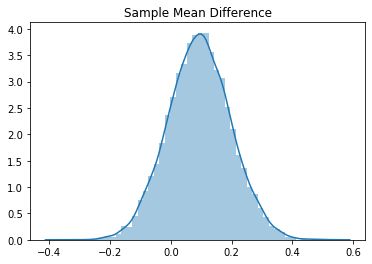

In [337]:
sample_mean_difference=np.array(sample_means_overall_treatment)-np.array(sample_means_overall_control)
sns.distplot(sample_mean_difference)
plt.title('Sample Mean Difference')

# Methods to Test Equivilancy of Distributions and Means

# 95% Confidence Intervals
Since the sampling distribution appears approximately normal, we can use the distribution to estimate a confidence interval. 

In [338]:
mean_boot=sample_mean_difference.mean()
mean_boot

0.09389072970138544

**Standard Error:** Since the distribution we are working on is a sampling distribution, the standard deviation is the standard error, instead of S/sqrt(n).

In [339]:
standard_error_boot=np.sqrt(sample_mean_difference.var())
standard_error_boot

0.10329511290563939

In [340]:
mean_boot+(1.96*standard_error_boot)

0.29634915099643866

In [341]:
mean_boot-(1.96*standard_error_boot)

-0.10856769159366776

**Conclusion:** Since 0 is within the estimated confidence interval, we cannot reject the possibility that the two distribution means are the same. 

# Bootstrap Permutation Test for Equal Distributions

In [342]:

meanT=fb_users_Treat[['approved_conversion']].mean()
meanC=fb_users_Control[['approved_conversion']].mean()
actual_diff=meanT-meanC
x=sample_mean_difference>actual_diff[0]
ASLboot=x.sum()/10000
###Acheived Significance Level
ASLboot

0.4997

# Bootstrap Permutation Test for Equality of Means

In [343]:
###Bootstrap Permutation Tests

###Test for Equal Means without Same Variance Assumption

full_data_mean=user_results_full[['approved_conversion']].mean()

####Adjust the distributions we will be re-sampling from:
adj_treat=fb_users_Treat[['approved_conversion']]-meanT+full_data_mean
adj_control=fb_users_Control[['approved_conversion']]-meanC+full_data_mean

actual_ts_tc_diff=(adj_treat.mean()-adj_control.mean())/np.sqrt((adj_treat.var()/nt)+(adj_control.var()/nc))
actual_ts_tc_diff

approved_conversion    5.283065e-14
dtype: float64

In [344]:
###Treatment Re-sampling
np.random.seed( 121)
resample_treatment = []

adj_treat=np.array(adj_treat)
adj_treat=adj_treat.flatten()

adj_control=np.array(adj_control)
adj_control=adj_control.flatten()

for i in range(10000):
    samplet = np.random.choice(adj_treat, size=nt)
    sample_meant=samplet.mean()
    sample_vart=samplet.var()
    
    samplec = np.random.choice(adj_control, size=nc)
    sample_meanc=samplec.mean()
    sample_varc=samplec.var()
    
    ts_tc_diff=(sample_meant-sample_meanc)/np.sqrt((sample_vart/nt)+(sample_varc/nc))
    
    resample_treatment.append(ts_tc_diff)

Text(0.5, 1.0, 'Bootstrap Distribution Approximation')

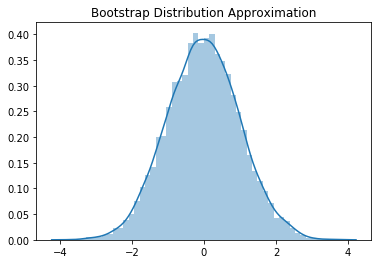

In [345]:
resample_treatment=np.array(resample_treatment)
sns.distplot(resample_treatment)
plt.title('Bootstrap Distribution Approximation')

In [346]:
p_val=resample_treatment>actual_ts_tc_diff[0]
ASLbootp=p_val.sum()/10000
###Acheived Significance Level
ASLbootp

0.4952

**Conclusion:** As expected, since the ASL p-value is greater than our chosen alpha=.05, we fail to reject the null hypothesis. In other words, the test tells us we are not finding a statistically significant difference between the group served the changes and the group not served the changes.   

# Alternative T Test Method (Bernoulli):
To corroborate our results, we can perform a T Test looking at the binary outcome of 'approved_conversion' rates.  i.e. Whether a purchase was made or not. Although this data is distributed as a bernoulli distribution, we can use an adjusted T Test method. 

In [347]:
####Create a Dummy Variable for Whether An Approved Conversion took place or not:
fb_users_Treat['AC_Dummy'] = fb_users_Treat.approved_conversion.apply(lambda x: 1 if x > 0 else 0)
fb_users_Control['AC_Dummy'] = fb_users_Control.approved_conversion.apply(lambda x: 1 if x > 0 else 0)
fb_users_Control

/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,reporting_start,reporting_end,age,gender,interest1,interest2,interest3,Treatment_Status,impressions,clicks,spent,total_conversion,approved_conversion,AC_Dummy
1,708749,17/08/2017,17/08/2017,30-34,M,16,19,21,0,17861,2,1.820000,2,0,0
2,708771,17/08/2017,17/08/2017,30-34,M,20,25,22,0,693,0,0.000000,1,0,0
4,708818,17/08/2017,17/08/2017,30-34,M,28,33,32,0,4133,1,1.290000,1,1,1
5,708820,17/08/2017,17/08/2017,30-34,M,29,30,30,0,1915,0,0.000000,1,1,1
6,708889,17/08/2017,17/08/2017,30-34,M,15,16,17,0,15615,3,4.770000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,1314407,19/08/2017,19/08/2017,45-49,F,106,112,108,0,107100,23,33.710001,1,0,0
1137,1314409,19/08/2017,19/08/2017,45-49,F,108,112,112,0,212508,33,47.690000,4,1,1
1139,1314411,19/08/2017,19/08/2017,45-49,F,110,111,116,0,637549,120,173.880003,3,0,0
1140,1314412,19/08/2017,19/08/2017,45-49,F,111,113,117,0,151531,28,40.289999,2,0,0


# T Test Difference in Means (Bernoulli): 
Since we are testing the difference in rates represented by a binary Bernoulli distribution, rather than using the sample variance, we calculate variance using the Bernoulli variance formula and sample mean. 

\begin{equation*}var=p*(1-p)\end{equation*}

\begin{equation*}
var_t = mean_t(1-mean_t)\end{equation*}

\begin{equation*}var_c = mean_c(1-mean_c)\end{equation*}



\begin{equation*}
tTestStat = \frac{mean_t-mean_c}{\sqrt{\frac{var_t}{n_t}+\frac{var_c}{n_c}}}
\end{equation*}


In [348]:
# T Test Variables (Bernoulli):

p_T=fb_users_Control['AC_Dummy'].mean()
p_C=fb_users_Treat['AC_Dummy'].mean()
nT2=len(fb_users_Treat)
nC2=len(fb_users_Control)

ber_var_T=p_T*(1-p_T)
ber_var_C=p_C*(1-p_C)



In [349]:
### Test Statistic ###
denominator=np.sqrt((ber_var_T/nT2)+(ber_var_C/nC2))
Ber_Test_Stat = (p_T-p_C)/denominator
Ber_Test_Stat

-0.4140849490608577

## Welch-Satterthwaite Formula for Degrees of Freedom
\begin{equation*}
DF = \frac{(\frac{var_t}{n_t}+\frac{var_c}{n_c})^2}{\frac{var_t^2}{n_t^2(n_t-1)}+\frac{var_c^2}{n_c^2(n_c-1)}}
\end{equation*}



In [350]:
###Welch-Satterthwaite Formula for Degrees of Freedom##
denominator_WS= ((ber_var_T**2/((nT2**2)*(nT2-1))) + (ber_var_C**2/((nC2**2)*(nC2-1))))
DF_WS=((ber_var_T/nT2)+(ber_var_C/nC2))**2/denominator_WS
print("Round Down:")
DF_WS

Round Down:


1133.8485143034086

In [351]:
###P-Value for Two Sided Test is 2 * CDF
p = stats.t.cdf(Ber_Test_Stat,df=DF_WS)*2
p


0.6788902119530689

**Conclusion:** The p-value still exceeds our .05 threshold reinforcing that we still cannot reject the change had **no effect.** 